# Atividade 3 - Naive Bayes e Regressão Logistica

## Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Naive bayes gaussiano

In [2]:
class GaussianNaiveBayes():
    
    def __init__(self):
        self._estimator_type = "classifier"
        self.c_mean = {} #objeto que armazena os vetores de medias para cada classe
        self.sigma = [] #Matriz de covariancia
        self.y_prob = {} #Objeto que armazena a probabilidade de cada classe
        pass
    
    #Estima a probabilidade de cada classe ocorrer
    # Estima a matriz de covariancia
    #Estima a media de cada classe
    def fit(self, X, y):
        self.labels, y_counts =  np.unique(y, return_counts=True)#Definindo classes, quantidade de valores em cada classe
        n_samples, self.n_features = X.shape #Definindo numero de amostras, número de atributos
        self.sigma = np.cov(X, rowvar=False) #Matriz de covariancia
        
        for label, y_count in zip(self.labels, y_counts):
            self.y_prob[label] = (y_count / y_counts.sum()) # Calcula a probabilidade de determinada classe ocorrer
            indices = np.where(y == label) # indices em que determinada classe ocorre
            x = np.array([X[index, :] for index in indices]).reshape(y_count,self.n_features) # Atributos que resultaram em determinada classe
            self.c_mean[label] = x.mean(axis=0) #Media calculada para determinada classe
        return self
                
            
    # Prediz o valor de y com base do x    
    def predict(self, X):
        predict = np.array([])
        n_samples = X.shape[0] # Numero de amostras
        #calcula P(C|x) para cada x em X
        for x in X:
            pred = np.array([])
            for label in self.labels:
                #calcula a formula P(X|C)
                aux = 1 / (np.power(2*np.pi, self.n_features / 2) * np.sqrt(np.linalg.det(self.sigma)))
                prob_x_c = aux * np.exp(-(1.0/2) * (x - self.c_mean[label]).T @ np.linalg.inv(self.sigma) @ (x - self.c_mean[label]))
                pred = np.append(pred, prob_x_c * self.y_prob[label]) # Salva P(X|C) * P(C) para cada classe C
            y_pred = self.labels[np.where(pred == pred.max())] # Obtem a classe com maior probabilidade
            predict = np.append(predict, y_pred) 
        return predict

## Discriminante quadratico gaussiano

In [3]:
class QuadraticDiscriminant():
    def __init__(self):
        self._estimator_type = "classifier"
        self.c_mean = {} #objeto que armazena os vetores de medias para cada classe
        self.sigma = {} #objeto que armazena as matrizes de covariancia para cada classe
        self.y_prob = {} #Objeto que armazena a probabilidade de cada classe
        pass
    
    def fit(self, X, y):
        self.labels, y_counts =  np.unique(y, return_counts=True) #Definindo classes, quantidade de valores em cada classe
        n_samples, self.n_features = X.shape #Definindo numero de amostras, número de atributos
        for label, y_count in zip(self.labels, y_counts):
            self.y_prob[label] = (y_count / y_counts.sum()) # calculo de probabilidade de cada classe
            indices = np.where(y == label) # indices em que determinada classe ocorre
            x = np.array([X[index, :] for index in indices]).reshape(y_count,self.n_features) # Atributos que resultaram em determinada classe
            self.c_mean[label] = x.mean(axis=0) #Media calculada para determinada classe
            self.sigma[label] = np.cov(x, rowvar=False) # Matriz de covariancia de cada classe
                
        return self        
        
    def predict(self, X):
        predict = np.array([])
        n_samples = X.shape[0] # Numero de amostras
        #calcula P(C|x) para cada x em X
        for x in X:
            pred = np.array([])
            for label in self.labels:
                #calcula a formula P(X|C)
                aux = 1 / (np.power(2*np.pi, self.n_features / 2) * np.sqrt(np.linalg.det(self.sigma[label])))
                prob_x_c = aux * np.exp(-(1.0/2) * (x - self.c_mean[label]).T @ np.linalg.inv(self.sigma[label]) @
                                        (x - self.c_mean[label]))
                pred = np.append(pred, prob_x_c * self.y_prob[label]) # Salva P(X|C) * P(C) para cada classe C
            y_pred = self.labels[np.where(pred == pred.max())] # Obtem a classe com maior probabilidade
            predict = np.append(predict, y_pred) 
        return predict

## Matriz de confusão

In [4]:
def plot_confusion_matrix_(X, y, clf):
    disp = plot_confusion_matrix(clf, X, y)
    disp.ax_.set_title("Matriz de confusão")
    plt.show()

## Gráfico de dispersão

In [5]:
def plot_boundaries(X, y, clf):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

## Avaliação de dados preditos

In [6]:
def avaliate(y_real, y_pred):
    count = 0
    for r, p in zip(y_real, y_pred):
        if r == p:
            count += 1
    return (count / y_real.shape[0])

## Carregando dados

In [7]:
data = np.loadtxt("./iris.data", delimiter=",")
np.random.shuffle(data)
X = data[:, 0:4]
y = data[:, -1]

## Divisão de dados em treino e teste

In [8]:
n = int(X.shape[0] * 0.6)
X_train = X[:n, :]
X_test = X[n:, :]
y_train = y[:n]
y_test = y[n:]
X_train_boundary = X[:n, :2]
X_test_boundary = X[n:, :2]

## Aplicando Naive bayes gausssiano

In [9]:
GaussianNB = GaussianNaiveBayes()
GaussianNB.fit(X_train, y_train)
LDA_pred = GaussianNB.predict(X_test)
print("avaliação: ", avaliate(y_test, LDA_pred))

avaliação:  0.7833333333333333


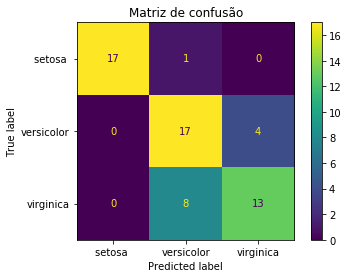

In [10]:
GaussianNB.classes_ =  ["setosa ","versicolor", "virginica"]
plot_confusion_matrix_(X_test, y_test, GaussianNB)

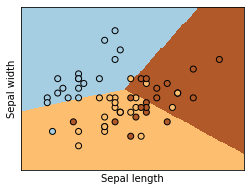

In [11]:
GaussianNB.fit(X_train_boundary, y_train)
plot_boundaries(X_test_boundary, y_test, GaussianNB)

## Aplicando discriminante quadratico gaussiano

In [12]:
QDA = QuadraticDiscriminant()
QDA.fit(X_train, y_train)
QDA_pred = QDA.predict(X_test)
print("avaliação: ", avaliate(y_test, QDA_pred))

avaliação:  0.9666666666666667


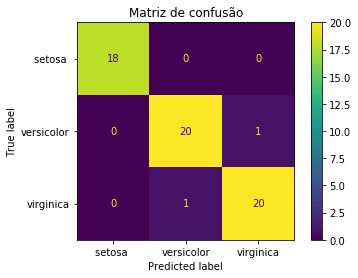

In [13]:
QDA.classes_ =  ["setosa ","versicolor", "virginica"]
plot_confusion_matrix_(X_test, y_test, QDA)

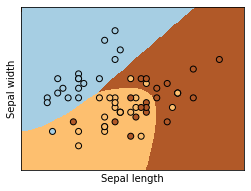

In [14]:
QDA.fit(X_train_boundary, y_train)
plot_boundaries(X_test_boundary, y_test, QDA)

## Aplicando regressão logística

In [15]:
LR = LogisticRegression(random_state=0, max_iter=200)
LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)
print("avaliação: ", avaliate(y_test, LR_pred))

avaliação:  0.8833333333333333


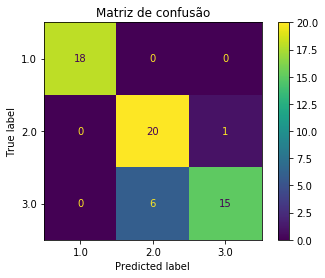

In [16]:
plot_confusion_matrix_(X_test, y_test, LR)

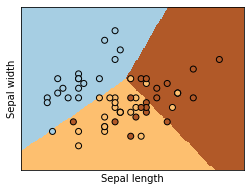

In [17]:
LR.fit(X_train_boundary, y_train)
plot_boundaries(X_test_boundary, y_test, LR)